In [40]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [5]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.3)

# Reading FE & Label

In [6]:
fe = pd.read_csv("outputs/fe.csv")
fe.head()

,weekId,max_duration,min_duration,mean_duration,sum_duration,std_duration,max_viewCount,min_viewCount,mean_viewCount,sum_viewCount,...,max_percLike,min_percLike,mean_percLike,sum_percLike,std_percLike,max_ratioLikeComment,min_ratioLikeComment,mean_ratioLikeComment,sum_ratioLikeComment,std_ratioLikeComment
0,101,996.0,959.0,977.500000,1955.0,26.162951,726428.0,165445.0,445936.50,891873.0,...,0.096632,0.057735,0.077183,0.154367,0.027504,21.552349,6.596685,14.074517,28.149034,10.575251
1,102,862.0,618.0,753.666667,2261.0,124.275232,258275.0,72186.0,136294.00,408882.0,...,0.061713,0.040538,0.051326,0.153978,0.010594,11.115385,2.765926,8.068166,24.204497,4.608927
2,103,1660.0,417.0,1035.500000,4142.0,579.811751,1101650.0,21376.0,406366.25,1625465.0,...,0.068806,0.039016,0.049685,0.198739,0.013436,27.457688,5.413547,12.363831,49.455324,10.164699
3,104,979.0,279.0,706.250000,2825.0,300.094846,1339138.0,28117.0,374999.25,1499997.0,...,0.077672,0.037486,0.058391,0.233563,0.019818,13.068862,2.966497,7.673158,30.692632,5.341116
4,105,1954.0,390.0,997.500000,3990.0,669.611081,368889.0,32923.0,208712.00,834848.0,...,0.081081,0.034900,0.055441,0.221763,0.019091,18.799497,5.075536,10.544267,42.177069,6.164214


In [7]:
label = pd.read_csv("outputs/spy_label.csv")
label["closeSign"] = label["ratioClose"].map(lambda x: 1 if x > 0 else 0)
label.tail()

,weekId,ratioClose,closeSign
283,284,-1.891455,0
284,285,1.756734,1
285,286,0.234233,1
286,287,3.440237,1
287,288,-1.183101,0


In [8]:
label = label[["weekId", "closeSign"]]

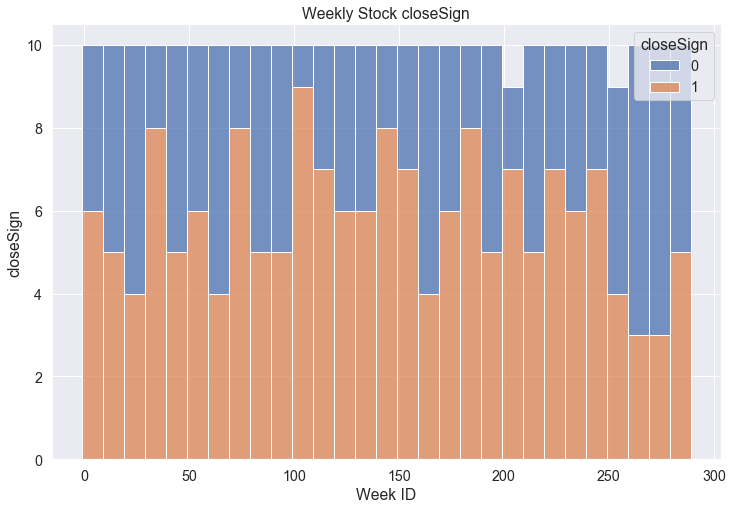

In [13]:
sns.histplot(data = label, x = "weekId", hue = "closeSign", multiple = "stack", binwidth=10).\
    set(title = "Weekly Stock closeSign", xlabel = "Week ID", ylabel = "closeSign")
plt.show()

# Preparing Modeling Dataset

In [14]:
data = fe.merge(label, how = "inner")
print(data.shape)

(186, 42)


In [15]:
corr = data[[c for c in data if c != "weekId"]].corr()

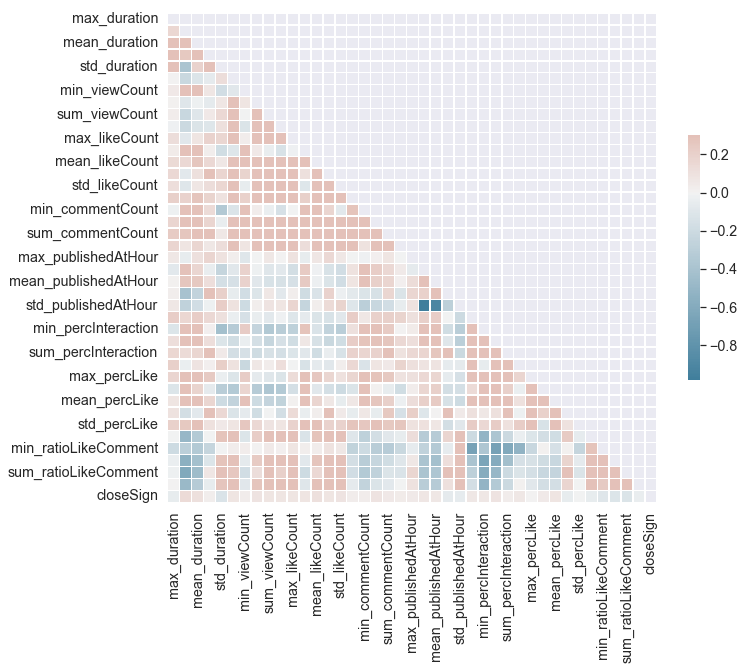

In [16]:
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Modeling Regression

In [25]:
X = data[[c for c in data.columns if c not in ["weekId", "closeSign"]]]
y = data["closeSign"]

scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scale, y, test_size = 0.3, random_state = 0)

## Classification Methods

In [41]:
models = {}

# Multi Layer Perceptron Classifier
models["MLPC"] = MLPClassifier(solver='lbfgs')

# XG Boost
models["XG Boost"] = xgb.XGBClassifier(objective="binary:logistic")

# Logistic Regression
models["Logistic Regression"] = LogisticRegression()

# Support Vector Machines
models["Support Vector Machines"] = LinearSVC()

# Decision Trees
models["Decision Trees"] = DecisionTreeClassifier()

# Random Forest
models["Random Forest"] = RandomForestClassifier()

# Naive Bayes
models["Naive Bayes"] = GaussianNB()

# K-Nearest Neighbors
models["K-Nearest Neighbor"] = KNeighborsClassifier()

In [42]:
accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier model
    models[key].fit(X_train, y_train)
    
    # Prediction 
    predictions = models[key].predict(X_test)
    
    # Calculate Accuracy, Precision and Recall Metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[13:21:41] WARNING: /private/var/folders/q0/v9ynk88x47l04s8srsdsvdrh0000gn/T/pip-install-s4equ239/xgboost_ddd3d7957ed74c17b1af5279b003a6a0/build/temp.macosx-10.9-x86_64-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [43]:
df_model = pd.DataFrame(index=models.keys(), columns=["Accuracy", "Precision", "Recall"])
df_model["Accuracy"] = accuracy.values()
df_model["Precision"] = precision.values()
df_model["Recall"] = recall.values()

df_model

,Accuracy,Precision,Recall
MLPC,0.607143,0.714286,0.588235
XG Boost,0.410714,0.607143,0.435897
Logistic Regression,0.535714,0.821429,0.522727
Support Vector Machines,0.482143,0.678571,0.487179
Decision Trees,0.482143,0.571429,0.484848
Random Forest,0.482143,0.750000,0.488372
Naive Bayes,0.410714,0.142857,0.307692
K-Nearest Neighbor,0.607143,0.892857,0.568182


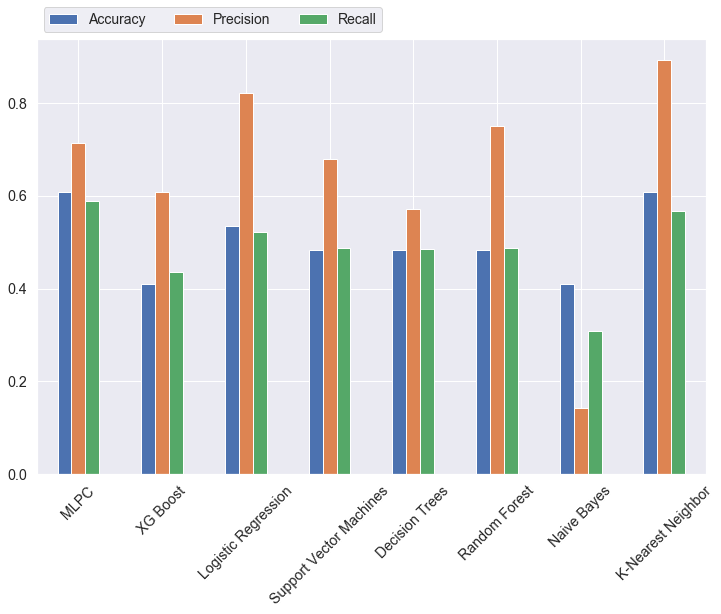

<Figure size 864x576 with 0 Axes>

In [44]:
ax  = df_model.plot.bar(rot=45)
fig = plt.figure(figsize=(12, 8))
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 14})
plt.tight_layout()
plt.show()

In [45]:
#"Logistic Regression"
#"Support Vector Machines"
#"Decision Trees"
#"Random Forest"
#"Naive Bayes"
#"K-Nearest Neighbor"

model_to_use = "K-Nearest Neighbor"

predictions = models[model_to_use].predict(X_test)
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print("True Positive (TP)  = ", TP)
print("False Positive (FP) = ", FP)
print("True Negative (TN)  = ", TN)
print("False Negative (FN) = ", FN)

accuracy = (TP+TN) / (TP+FP+TN+FN)

print("Accuracy of the binary classification = {:0.3f}".format(accuracy))

True Positive (TP)  =  25
False Positive (FP) =  19
True Negative (TN)  =  9
False Negative (FN) =  3
Accuracy of the binary classification = 0.607
